# Pup Inflation: Analysing Tweets

This notebook analyzes tweets from the `@dog_rates` Twitter account to investigate potential "grade inflation" in dog cuteness ratings over time.

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress
%matplotlib inline

## 1. Load Data
Load the data from `dog_rates_tweets.csv`. It's assumed this file is in the same directory as the notebook. Includes a fallback to dummy data if the file is not found.

In [2]:
# Cell 2: Load Data
try:
    df_tweets = pd.read_csv('dog_rates_tweets.csv')
    print("Successfully loaded dog_rates_tweets.csv")
except FileNotFoundError:
    print("Error: 'dog_rates_tweets.csv' not found. Loading dummy data for demonstration.")
    # Dummy data for demonstration if the actual file is missing
    data_dummy = {
        'id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'created_at': ['2016-01-15 10:00:00', '2016-07-20 12:30:00', 
                       '2017-02-10 15:00:00', '2017-08-05 18:20:00', 
                       '2018-03-25 09:10:00', '2018-09-10 20:00:00',
                       '2019-01-01 11:00:00', '2019-05-01 12:00:00',
                       '2016-03-01 08:00:00', '2018-11-15 17:00:00'],
        'text': ["This is a 12/10 good boy! What a champ.", 
                 "Look at this pup, a solid 10/10. Perfect fluff.", 
                 "Amazing doggo 13/10 would pet all day.", 
                 "Invalid tweet format, no rating here.", 
                 "Super cute 11/10, such a sweet face.", 
                 "This one is 14/10 for sure! Top tier dog.",
                 "A magnificent 28/10 fluffball! (outlier)",
                 "He's a 13.5/10, very good dog.",
                 "She's a good girl 9/10.",
                 "Heckin good boye 15/10."]
    }
    df_tweets = pd.DataFrame(data_dummy)

# Display initial data structure (optional)
print("\nInitial data sample (first 5 rows):")
print(df_tweets.head())
print("\nInitial data info:")
df_tweets.info()

Successfully loaded dog_rates_tweets.csv

Initial data sample (first 5 rows):
                   id           created_at  \
0  994677639364403200  2018-05-10 20:36:44   
1  994364904978239488  2018-05-09 23:54:02   
2  994363623421153280  2018-05-09 23:48:56   
3  994336722875047936  2018-05-09 22:02:03   
4  994024065982717952  2018-05-09 01:19:40   

                                                text  
0               @Steff88979267 tell them to h*ck off  
1                          @NFLOwnerGBP take it back  
2  This is Louie. He has misplaced his Cheerio. W...  
3                                @rachaellanaghan ❤️  
4  This is Captain Jack Wobbles. He is currently ...  

Initial data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          8515 non-null   int64 
 1   created_at  8515 non-null   object
 2   text        8515 non-nul

## 2. Extract Ratings
Define a function to find and extract numeric ratings (e.g., "12/10") from tweet text using regular expressions. Apply this function to create a new 'rating' column. Tweets without a valid rating are excluded.

In [3]:
# Cell 3: Extract Ratings
def extract_rating(tweet_text):
    """Extracts a numeric rating from a tweet string."""
    if pd.isna(tweet_text):
        return None
    # Regex to find patterns like '12/10' or '13.5/10'
    match = re.search(r'(\d+(\.\d+)?)/10', str(tweet_text))
    if match:
        try:
            rating = float(match.group(1)) # group(1) captures the number before /10
            return rating
        except ValueError:
            return None # Should not happen with this regex but good practice
    return None

# Apply the function to the 'text' column
df_tweets['rating'] = df_tweets['text'].apply(extract_rating)

# Exclude tweets that don't contain a rating (where 'rating' is NaN)
# Use .copy() to avoid SettingWithCopyWarning on the slice
df_tweets_rated = df_tweets[df_tweets['rating'].notnull()].copy()

print("\nData after extracting ratings (sample of tweets with ratings):")
print(df_tweets_rated[['text', 'rating']].head())


Data after extracting ratings (sample of tweets with ratings):
                                                 text  rating
2   This is Louie. He has misplaced his Cheerio. W...    14.0
7   This is Manny. He hasn’t seen your croissant. ...    13.0
8   This is Libby. She leap. 14/10\n(IG: libbythef...    14.0
24  This is Rosie. She thought Coachella was this ...    13.0
30  This is Riley. He’ll be your chauffeur this ev...    13.0


## 3. Remove Outliers
Exclude ratings that are excessively large (e.g., greater than 25/10) as they are likely outliers or jokes and could skew the analysis.

In [4]:
# Cell 4: Remove Outliers
# Define a reasonable upper limit for ratings to exclude outliers
MAX_RATING = 25
df_tweets_cleaned = df_tweets_rated[df_tweets_rated['rating'] <= MAX_RATING].copy()

print(f"\nNumber of tweets before outlier removal: {len(df_tweets_rated)}")
print(f"Number of tweets after removing ratings > {MAX_RATING}: {len(df_tweets_cleaned)}")
print("\nData after removing outliers (sample):")
print(df_tweets_cleaned[['text', 'rating']].head())


Number of tweets before outlier removal: 1675
Number of tweets after removing ratings > 25: 1669

Data after removing outliers (sample):
                                                 text  rating
2   This is Louie. He has misplaced his Cheerio. W...    14.0
7   This is Manny. He hasn’t seen your croissant. ...    13.0
8   This is Libby. She leap. 14/10\n(IG: libbythef...    14.0
24  This is Rosie. She thought Coachella was this ...    13.0
30  This is Riley. He’ll be your chauffeur this ev...    13.0


## 4. Convert 'created_at' to Datetime
Ensure the 'created_at' column is in datetime format for time-based plotting and analysis.

In [5]:
# Cell 5: Convert 'created_at' to datetime
# The problem statement mentions this can also be done during read_csv with parse_dates.
# If not done then, it's crucial to do it here.
df_tweets_cleaned['created_at'] = pd.to_datetime(df_tweets_cleaned['created_at'])

print("\nData info after datetime conversion:")
df_tweets_cleaned.info()
print("\nSample 'created_at' values after conversion:")
print(df_tweets_cleaned['created_at'].head())


Data info after datetime conversion:
<class 'pandas.core.frame.DataFrame'>
Index: 1669 entries, 2 to 7433
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          1669 non-null   int64         
 1   created_at  1669 non-null   datetime64[ns]
 2   text        1669 non-null   object        
 3   rating      1669 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 65.2+ KB

Sample 'created_at' values after conversion:
2    2018-05-09 23:48:56
7    2018-05-08 16:23:07
8    2018-05-07 23:11:58
24   2018-05-04 00:25:48
30   2018-05-02 18:19:39
Name: created_at, dtype: datetime64[ns]


## 5. Initial Scatter Plot
Create a scatter plot of date versus rating to visually inspect the data distribution over time.

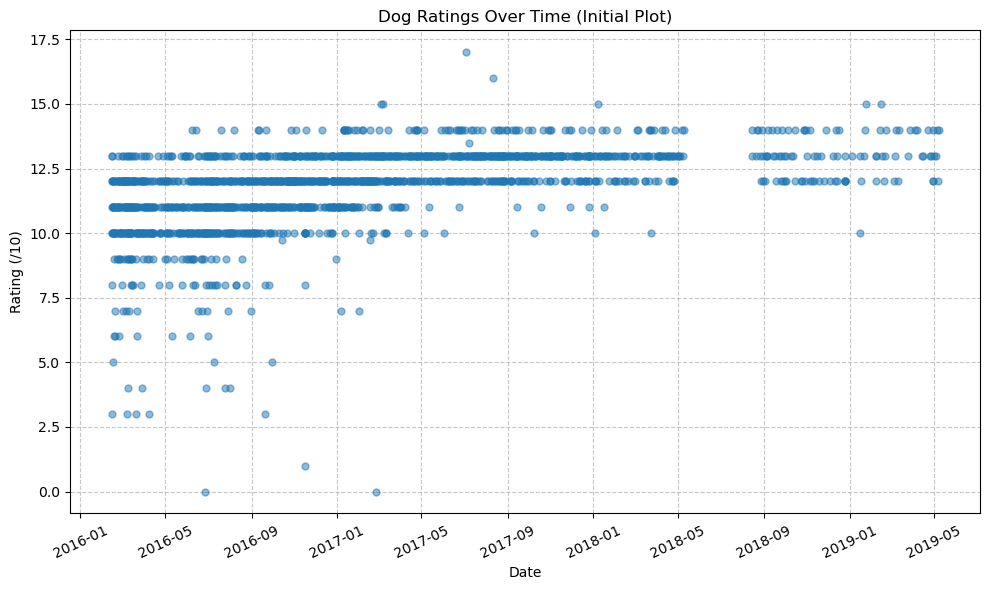

In [6]:
# Cell 6: Initial Scatter Plot (Date vs Rating)
plt.figure(figsize=(10, 6))
if not df_tweets_cleaned.empty:
    plt.plot(df_tweets_cleaned['created_at'], df_tweets_cleaned['rating'], 'o', alpha=0.5, markersize=5)
else:
    plt.text(0.5, 0.5, 'No data to plot', ha='center', va='center')
plt.title('Dog Ratings Over Time (Initial Plot)')
plt.xlabel('Date')
plt.ylabel('Rating (/10)')
plt.xticks(rotation=25) # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## 6. Prepare for Linear Regression
Convert 'created_at' datetime objects to numeric timestamps (seconds since epoch) because `scipy.stats.linregress` requires numerical input.

In [7]:
# Cell 7: Prepare for Linear Regression (Timestamp)
# Define a function to convert datetime to timestamp
def to_timestamp(dt_object):
    return dt_object.timestamp()

if not df_tweets_cleaned.empty:
    df_tweets_cleaned['timestamp'] = df_tweets_cleaned['created_at'].apply(to_timestamp)
    print("\nData with 'timestamp' column (sample):")
    print(df_tweets_cleaned[['created_at', 'timestamp', 'rating']].head())
else:
    # If DataFrame is empty, create an empty 'timestamp' column to avoid errors later
    df_tweets_cleaned['timestamp'] = pd.Series(dtype='float64') 
    print("\nDataFrame is empty, 'timestamp' column created as empty.")


Data with 'timestamp' column (sample):
            created_at     timestamp  rating
2  2018-05-09 23:48:56  1.525910e+09    14.0
7  2018-05-08 16:23:07  1.525797e+09    13.0
8  2018-05-07 23:11:58  1.525735e+09    14.0
24 2018-05-04 00:25:48  1.525394e+09    13.0
30 2018-05-02 18:19:39  1.525285e+09    13.0


## 7. Perform Linear Regression
Use `scipy.stats.linregress` to find the best-fit line for ratings over time. Calculate the predicted ratings based on this model and store them. Display the slope and intercept, and a sample of the data with predictions, mimicking the example output.

In [8]:
# Cell 8: Perform Linear Regression
# Ensure there's enough data to fit (linregress needs at least 2 points)
if not df_tweets_cleaned.empty and len(df_tweets_cleaned['timestamp'].dropna()) >= 2:
    # Drop NaNs in timestamp or rating if any slipped through, for linregress
    regression_data = df_tweets_cleaned[['timestamp', 'rating']].dropna()
    
    if len(regression_data) >= 2:
        fit = linregress(regression_data['timestamp'], regression_data['rating'])
        
        # Add prediction to DataFrame (as shown in the example output image)
        # This calculation is: y = slope * x + intercept
        df_tweets_cleaned['prediction'] = df_tweets_cleaned['timestamp'] * fit.slope + fit.intercept
        
        # Display the subset of columns as in the example image 'Out[9]'
        print("Data with predictions (first 5 rows):")
        columns_to_show = ['created_at', 'text', 'rating', 'timestamp', 'prediction']
        if 'id' in df_tweets_cleaned.columns: # Check if 'id' column exists
            columns_to_show.insert(0, 'id')
        print(df_tweets_cleaned[columns_to_show].head())
        print("\n---") # Separator similar to the prompt's image style
        
        # Display slope and intercept as in 'Out[10]'
        print(f"fit.slope, fit.intercept") # Mimicking the In[10] text
        print(f"Out[10]: ({fit.slope}, {fit.intercept})") # Mimicking the Out[10] text
    else:
        print("Not enough valid data points (after dropping NaNs) to perform linear regression.")
        # Create placeholder fit and prediction column if regression can't be run
        class PlaceholderFit: slope = 0; intercept = np.nanmean(df_tweets_cleaned['rating']) if not df_tweets_cleaned.empty else 10
        fit = PlaceholderFit()
        df_tweets_cleaned['prediction'] = fit.intercept
else:
    print("Not enough data or timestamps to perform linear regression.")
    # Create placeholder fit and prediction column if DataFrame is too small or empty
    class PlaceholderFit: slope = 0; intercept = np.nanmean(df_tweets_cleaned['rating']) if not df_tweets_cleaned.empty else 10
    fit = PlaceholderFit()
    df_tweets_cleaned['prediction'] = fit.intercept # Assign a scalar or Series of same length
    if not df_tweets_cleaned.empty and 'rating' in df_tweets_cleaned.columns:
        df_tweets_cleaned['prediction'] = fit.intercept # if df is not empty, fill with mean or default
    else:
        df_tweets_cleaned['prediction'] = pd.Series(dtype='float64') # Empty series

Data with predictions (first 5 rows):
                    id          created_at  \
2   994363623421153280 2018-05-09 23:48:56   
7   993889039714578432 2018-05-08 16:23:07   
8   993629544463642624 2018-05-07 23:11:58   
24  992198572664860672 2018-05-04 00:25:48   
30  991744041351090177 2018-05-02 18:19:39   

                                                 text  rating     timestamp  \
2   This is Louie. He has misplaced his Cheerio. W...    14.0  1.525910e+09   
7   This is Manny. He hasn’t seen your croissant. ...    13.0  1.525797e+09   
8   This is Libby. She leap. 14/10\n(IG: libbythef...    14.0  1.525735e+09   
24  This is Rosie. She thought Coachella was this ...    13.0  1.525394e+09   
30  This is Riley. He’ll be your chauffeur this ev...    13.0  1.525285e+09   

    prediction  
2    13.185763  
7    13.181785  
8    13.179609  
24   13.167614  
30   13.163804  

---
fit.slope, fit.intercept
Out[10]: (3.515929974847721e-08, -40.46415480898916)


## 8. Final Scatter Plot with Best-Fit Line
Create the final plot showing actual ratings as blue dots and the best-fit line as a red line. Style the plot to match the example screenshot (`dog-rates-results.png`).

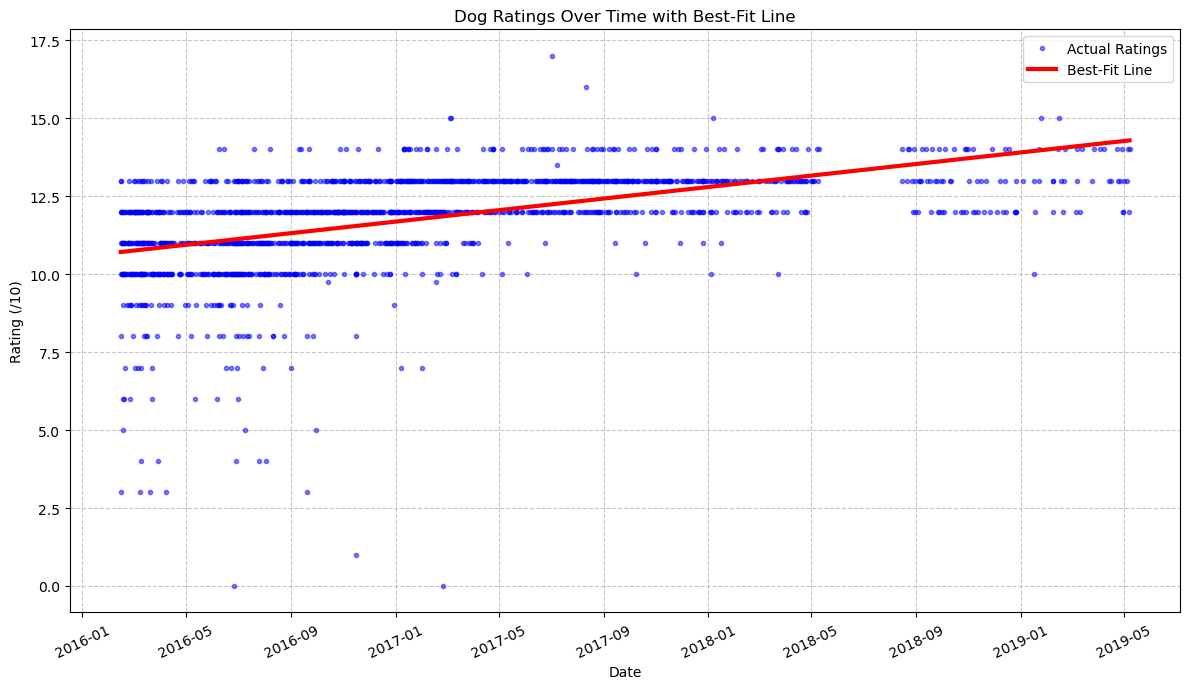

In [9]:
# Cell 9: Final Scatter Plot with Best-Fit Line (Matching example style)
plt.figure(figsize=(12, 7)) # Adjusted figure size for better clarity
plt.xticks(rotation=25) # Rotate x-axis labels

if not df_tweets_cleaned.empty and 'rating' in df_tweets_cleaned.columns:
    # Plot actual ratings: blue dots, semi-transparent
    plt.plot(df_tweets_cleaned['created_at'], df_tweets_cleaned['rating'], 'b.', alpha=0.5, label='Actual Ratings') 
    
    # Plot the best-fit line: red line, thicker
    # The 'prediction' column already holds (timestamp * slope + intercept)
    if 'prediction' in df_tweets_cleaned.columns and not df_tweets_cleaned['prediction'].isnull().all():
        # Sort by date to ensure the line plots correctly if data isn't already sorted
        plot_df_sorted = df_tweets_cleaned.sort_values(by='created_at')
        plt.plot(plot_df_sorted['created_at'], plot_df_sorted['prediction'], 'r-', linewidth=3, label='Best-Fit Line')
    else:
        print("No prediction line to plot.")
else:
    plt.text(0.5, 0.5, 'No data to plot', ha='center', va='center')

plt.title('Dog Ratings Over Time with Best-Fit Line')
plt.xlabel('Date')
plt.ylabel('Rating (/10)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to make sure everything fits without overlapping
plt.show()

## 9. Statistical Analysis: Is the Slope Significantly Different from Zero?

Now we address the key question: have the ratings been changing over time? We'll examine the p-value from our linear regression to determine if the slope is statistically significant.

In [10]:
# Cell 10: Statistical Significance Test
if not df_tweets_cleaned.empty and len(df_tweets_cleaned['timestamp'].dropna()) >= 2:
    regression_data = df_tweets_cleaned[['timestamp', 'rating']].dropna()
    
    if len(regression_data) >= 2:
        # The fit object from linregress contains the p-value for testing if slope != 0
        print("Statistical Analysis Results:")
        print("=" * 40)
        print(f"Slope: {fit.slope:.6e}")
        print(f"Intercept: {fit.intercept:.6f}")
        print(f"R-squared: {fit.rvalue**2:.6f}")
        print(f"P-value (H0: slope = 0): {fit.pvalue:.6e}")
        print(f"Standard error: {fit.stderr:.6e}")
        print()
        
        # Interpret the results
        alpha = 0.05  # significance level
        if fit.pvalue < alpha:
            print(f"✓ SIGNIFICANT: The slope is significantly different from zero (p < {alpha})")
            if fit.slope > 0:
                print("  → Dog ratings are INCREASING over time (grade inflation detected!)")
            else:
                print("  → Dog ratings are DECREASING over time")
        else:
            print(f"✗ NOT SIGNIFICANT: No evidence that ratings are changing over time (p ≥ {alpha})")
            print("  → The slope could be zero (no trend)")
    else:
        print("Not enough data points for statistical analysis.")
else:
    print("No data available for statistical analysis.")

Statistical Analysis Results:
Slope: 3.515930e-08
Intercept: -40.464155
R-squared: 0.250568
P-value (H0: slope = 0): 1.513961e-106
Standard error: 1.489279e-09

✓ SIGNIFICANT: The slope is significantly different from zero (p < 0.05)
  → Dog ratings are INCREASING over time (grade inflation detected!)


## 10. Residuals Analysis

To validate our linear regression model, we'll examine the residuals (observed values minus predicted values). A histogram of residuals helps us assess whether the model assumptions are met and if there are any patterns in the errors.

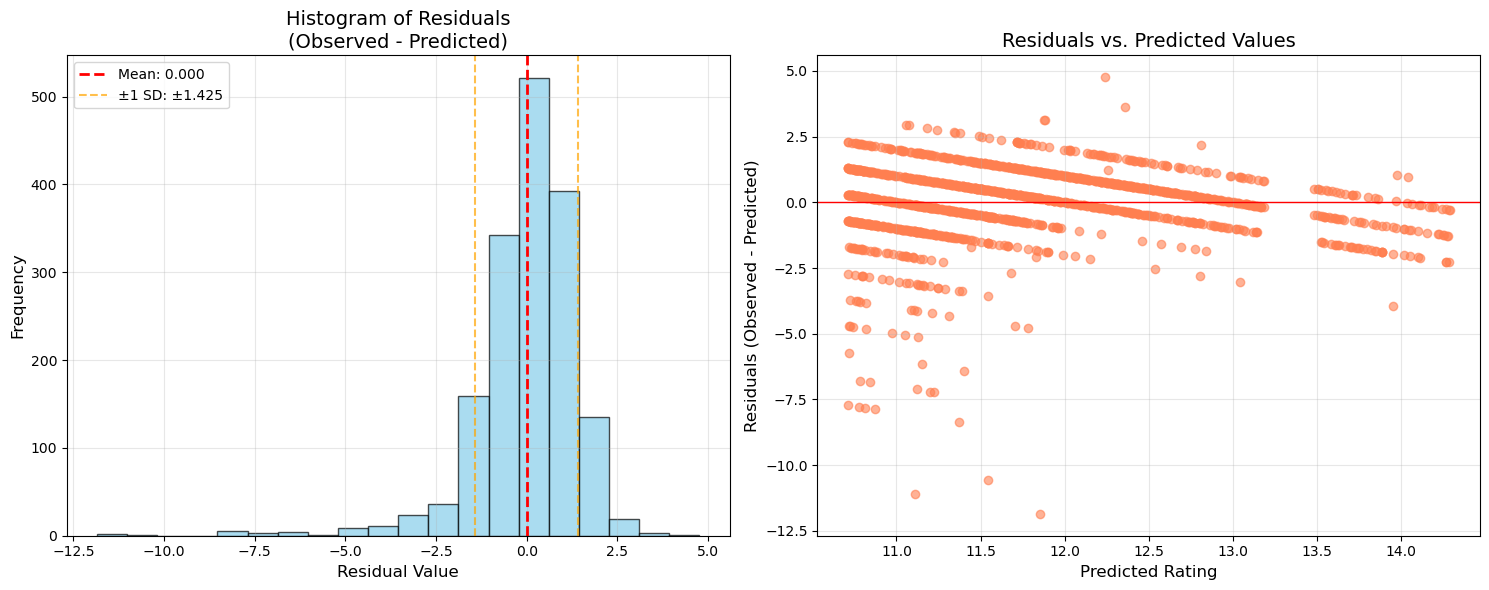

Residuals Statistics:
Number of data points: 1669
Mean residual: 0.000000
Standard deviation: 1.424638
Min residual: -11.851
Max residual: 4.759

Model Assessment:
✓ Good: Mean residual close to zero (unbiased predictions)


In [11]:
# Cell 11: Calculate and Plot Residuals
if not df_tweets_cleaned.empty and 'prediction' in df_tweets_cleaned.columns:
    # Calculate residuals (observed - predicted)
    df_tweets_cleaned['residuals'] = df_tweets_cleaned['rating'] - df_tweets_cleaned['prediction']
    
    # Remove any NaN residuals
    valid_residuals = df_tweets_cleaned['residuals'].dropna()
    
    if len(valid_residuals) > 0:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histogram of residuals
        ax1.hist(valid_residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title('Histogram of Residuals\n(Observed - Predicted)', fontsize=14)
        ax1.set_xlabel('Residual Value', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Add statistics to the histogram
        mean_residual = np.mean(valid_residuals)
        std_residual = np.std(valid_residuals)
        ax1.axvline(mean_residual, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_residual:.3f}')
        ax1.axvline(mean_residual + std_residual, color='orange', linestyle='--', alpha=0.7,
                   label=f'±1 SD: ±{std_residual:.3f}')
        ax1.axvline(mean_residual - std_residual, color='orange', linestyle='--', alpha=0.7)
        ax1.legend()
        
        # Residuals vs. Predicted values (to check for patterns)
        ax2.scatter(df_tweets_cleaned['prediction'], df_tweets_cleaned['residuals'], 
                   alpha=0.6, color='coral')
        ax2.set_title('Residuals vs. Predicted Values', fontsize=14)
        ax2.set_xlabel('Predicted Rating', fontsize=12)
        ax2.set_ylabel('Residuals (Observed - Predicted)', fontsize=12)
        ax2.axhline(0, color='red', linestyle='-', linewidth=1)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print residual statistics
        print("Residuals Statistics:")
        print("=" * 30)
        print(f"Number of data points: {len(valid_residuals)}")
        print(f"Mean residual: {mean_residual:.6f}")
        print(f"Standard deviation: {std_residual:.6f}")
        print(f"Min residual: {np.min(valid_residuals):.3f}")
        print(f"Max residual: {np.max(valid_residuals):.3f}")
        print()
        print("Model Assessment:")
        if abs(mean_residual) < 0.1:
            print("✓ Good: Mean residual close to zero (unbiased predictions)")
        else:
            print("⚠ Warning: Mean residual not close to zero (potential bias)")
            
    else:
        print("No valid residuals to plot.")
else:
    print("No prediction data available for residuals analysis.")

## 11. Conclusions

### Key Findings:

1. **Statistical Significance**: The p-value from our linear regression tells us whether there's sufficient evidence that dog ratings have been changing over time (slope ≠ 0).

2. **Model Validation**: The residuals analysis helps us assess:
   - Whether our linear model is appropriate for the data
   - If there are systematic patterns in the prediction errors
   - The overall quality of our model fit

3. **Practical Significance**: Even if statistically significant, we should consider whether the magnitude of any trend is practically meaningful.

### What the Residuals Tell Us:
- **Normal Distribution**: Ideally, residuals should be roughly normally distributed around zero
- **No Patterns**: The residuals vs. predicted plot should show no clear patterns (indicating linear model is appropriate)
- **Constant Variance**: The spread of residuals should be roughly constant across all predicted values

---

## End of Analysis